# Walmart Store-Level Sales Forecasting  
## Exploratory Data Analysis

### Project overview
This project explores weekly sales patterns at the store and department level using historical Walmart data. The goal is to understand how the data behaves over time and what limitations it has before attempting any forecasting or modeling.

In a retail context, forecasting affects inventory, staffing, and promotions, so this work treats forecasting as a decision-support problem rather than a purely predictive one.

### About the data
The dataset includes weekly sales by store and department, along with holiday indicators, promotional markdowns (with substantial missingness), external economic variables, and store-level metadata. The data reflects real operational challenges, including incomplete records and uneven coverage across stores and departments.

### Purpose of this notebook
This notebook focuses strictly on exploration and validation:
- Reviewing data structure and time coverage  
- Examining missing values and data quality issues  
- Identifying challenges that will affect downstream modeling  

No modeling, feature engineering, or imputation is performed at this stage.

### Project context
This analysis serves as the foundation for later modeling work. Any data cleaning or modeling decisions made in later notebooks will be informed by observations documented here.


In [1]:
#imports
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#load data from folder
DATA_DIR = "../data/raw"

train = pd.read_csv(f"{DATA_DIR}/train.csv", parse_dates=["Date"])
features = pd.read_csv(f"{DATA_DIR}/features.csv", parse_dates=["Date"])
stores = pd.read_csv(f"{DATA_DIR}/stores.csv")
test = pd.read_csv(f"{DATA_DIR}/test.csv", parse_dates=["Date"])


In [3]:
#initial eda
train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [4]:
features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [5]:
stores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [6]:
test.head()

,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False
2,1,1,2012-11-16,False
3,1,1,2012-11-23,True
4,1,1,2012-11-30,False


## Initial Data Inspection and Validation

This section begins the data wrangling process by focusing on basic validation rather than transformation. Before making any cleaning or modeling decisions, the goal is to understand the structure of each dataset, confirm data types, and identify the extent and patterns of missing values.

Some initial spot checks were performed outside of Python to get a rough sense of the data, but all validation here is done programmatically to ensure reproducibility. At this stage, no values are modified or imputed. The intent is to document potential data quality issues that will influence downstream cleaning and modeling decisions.


In [8]:
features.isna().sum()

Store              0
Date               0
Temperature        0
Fuel_Price         0
MarkDown1       4158
MarkDown2       5269
MarkDown3       4577
MarkDown4       4726
MarkDown5       4140
CPI              585
Unemployment     585
IsHoliday          0
dtype: int64

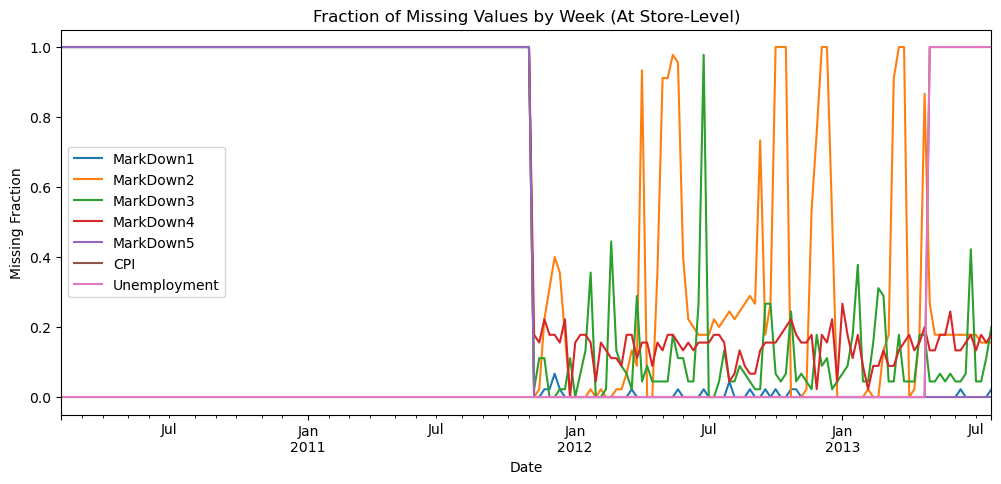

In [13]:
#lets start looking at how these missing values relate to time by building a table and plotting by week
missing_time = (
    features
    .assign(week=features["Date"])
    .set_index("week")
    [["MarkDown1", "MarkDown2", "MarkDown3", "MarkDown4", "MarkDown5", "CPI", "Unemployment"]]
    .isna()
    .astype(int)
)

#now ask: for a given week what percent of stores have missig values for these columns?
weekly_missing_rate = missing_time.groupby(level=0).mean()

weekly_missing_rate.plot(
    figsize=(12, 5),
    title="Fraction of Missing Values by Week (At Store-Level)"
)
plt.ylabel("Missing Fraction")
plt.xlabel("Date")
plt.show()


Missingness patterns vary substantially across features. Several markdown
variables exhibit extended periods of near-complete missingness early in the
dataset, suggesting that these promotions were either not active or not
recorded during those periods. Other markdown variables appear intermittently,
consistent with event-driven promotional activity rather than random data loss.
In contrast, macroeconomic variables such as CPI and unemployment are largely
complete, with missing values concentrated near dataset boundaries.


## Missingness by Store
Since we found patterns for missingness over time lets look at store level now.

In [23]:
markdown_cols = [
    "MarkDown1", "MarkDown2", "MarkDown3",
    "MarkDown4", "MarkDown5"
]

store_missing = {}

#loop through markdown columns and find missingness by each store and markdown level
for col in markdown_cols:
    store_missing[col] = (
        features
        .groupby("Store")[col]
        .apply(lambda x: x.isna().mean())
    )

store_missing_df = pd.DataFrame(store_missing)
store_missing_df.head(10)

,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5
Store,,,,,
1,0.505495,0.598901,0.510989,0.505495,0.505495
2,0.505495,0.587912,0.510989,0.505495,0.505495
3,0.505495,0.620879,0.571429,0.521978,0.505495
4,0.505495,0.587912,0.516484,0.516484,0.505495
5,0.505495,0.637363,0.582418,0.538462,0.505495
6,0.505495,0.587912,0.516484,0.505495,0.505495
7,0.505495,0.637363,0.527473,0.505495,0.505495
8,0.505495,0.598901,0.521978,0.516484,0.505495
9,0.505495,0.653846,0.576923,0.538462,0.505495


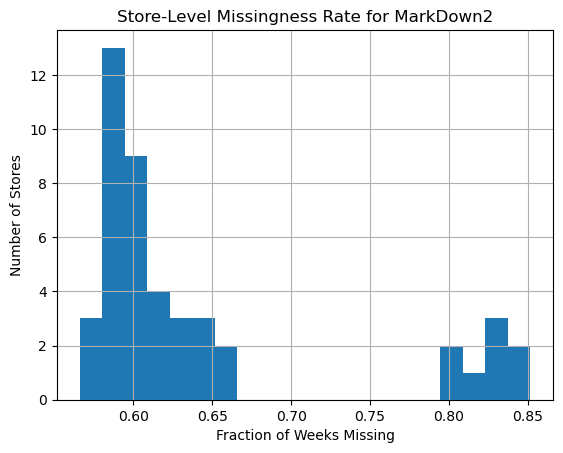

In [22]:
#lets randomly select a markdown to plot to help see the distribution of missingness across all the stores
store_missing_df["MarkDown2"].hist(bins=20)
plt.title("Store-Level Missingness Rate for MarkDown2")
plt.xlabel("Fraction of Weeks Missing")
plt.ylabel("Number of Stores")
plt.show()


## Relationship Between Missingness and Store Characteristics
Now that we have indentified patterns for missingness in relation to store and time lets also see if there are any patterns between missingness and specific store characteristics

In [26]:
#we first need to merge store characteristics to the missing data set (also at store level) to access this data
store_missing_chars = (
    store_missing_df
    .merge(stores, left_index=True, right_on="Store", how="left")
)

#group stores by their given type and check missingness descriptive stats for markdown 2 
store_missing_chars.groupby("Type")["MarkDown2"].describe()


,count,mean,std,min,25%,50%,75%,max
Type,,,,,,,,
A,22.0,0.609890,0.064901,0.565934,0.587912,0.590659,0.598901,0.813187
B,17.0,0.620879,0.021012,0.582418,0.604396,0.620879,0.637363,0.659341
C,6.0,0.829670,0.015147,0.807692,0.824176,0.826923,0.837912,0.851648


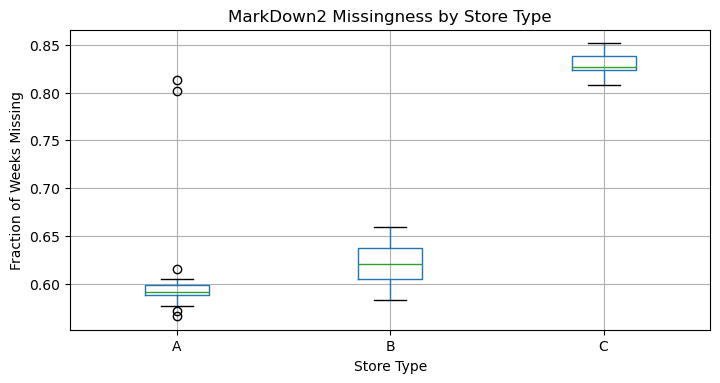

In [28]:
#lets visualize this since type C has significantly more missing values for markdown 2
store_missing_chars.boxplot(
    column="MarkDown2",
    by="Type",
    figsize=(8, 4)
)
plt.title("MarkDown2 Missingness by Store Type")
plt.suptitle("")
plt.xlabel("Store Type")
plt.ylabel("Fraction of Weeks Missing")
plt.show()


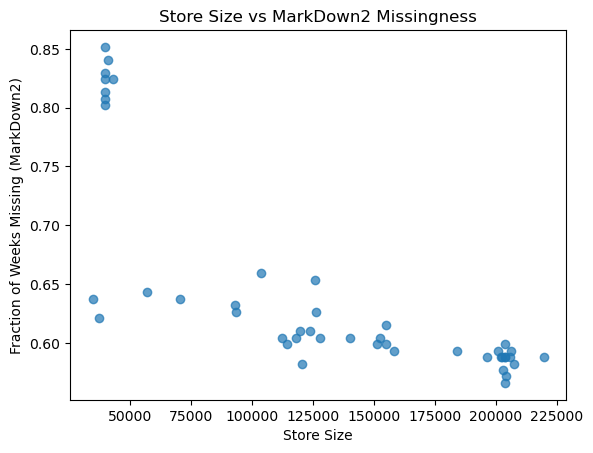

In [30]:
#also should look at if there is any correlation with store size to markdown missingness
plt.scatter(
    store_missing_chars["Size"],
    store_missing_chars["MarkDown2"],
    alpha=0.7
)
plt.xlabel("Store Size")
plt.ylabel("Fraction of Weeks Missing (MarkDown2)")
plt.title("Store Size vs MarkDown2 Missingness")
plt.show()


## Missingness Conclusions
Markdown availability is strongly associated with store characteristics.
Store Type C exhibits consistently high missingness for MarkDown2, suggesting
that this promotion is rarely applicable to those locations. Larger stores
tend to have lower missingness rates, indicating greater participation in
markdown activity. These patterns suggest that markdown variables encode
meaningful business structure rather than random data gaps.


## Sales Target Analysis

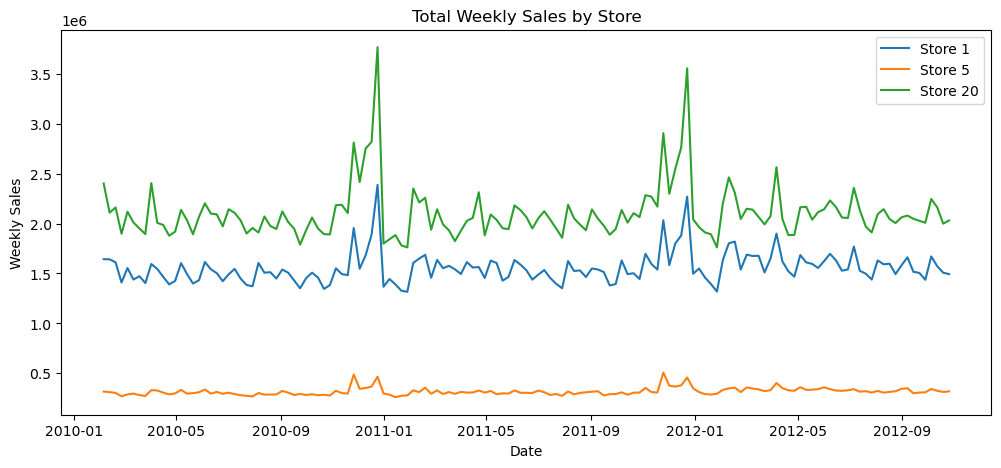

In [31]:
#first start by looking at high level sales over time
store_weekly_sales = (
    train
    .groupby(["Store", "Date"], as_index=False)["Weekly_Sales"]
    .sum()
)

#lets pick a subset of these stores (one small, medium, and large)
stores_to_plot = [1, 5, 20]

plt.figure(figsize=(12, 5))

for store in stores_to_plot:
    s = store_weekly_sales[
        store_weekly_sales["Store"] == store
    ].sort_values("Date")
    
    plt.plot(s["Date"], s["Weekly_Sales"], label=f"Store {store}")

plt.legend()
plt.title("Total Weekly Sales by Store")
plt.xlabel("Date")
plt.ylabel("Weekly Sales")
plt.show()



Aggregated store-level sales reveal substantial differences in scale and
volatility across locations. Despite these differences, all stores exhibit
strong seasonal patterns and synchronized demand spikes, particularly around
holiday periods. This suggests that while demand magnitude varies by store,
temporal structure is broadly shared, motivating models that account for both
global seasonality and store-specific effects.


## Decomposition of Store-Level Sales Trends


My goal for this step is to explore sationarity of sales over time and see how much variation is accounted for by time index, seasonality, or shocks. I am looking to apply my approach to forecasting inflation to this methodology and aim to discover past movement rather than just time index. 

Trend → “Where is demand drifting over years?”

Seasonality → “What repeats every year regardless of shocks?”

Residual → “What’s left that models must explain?”

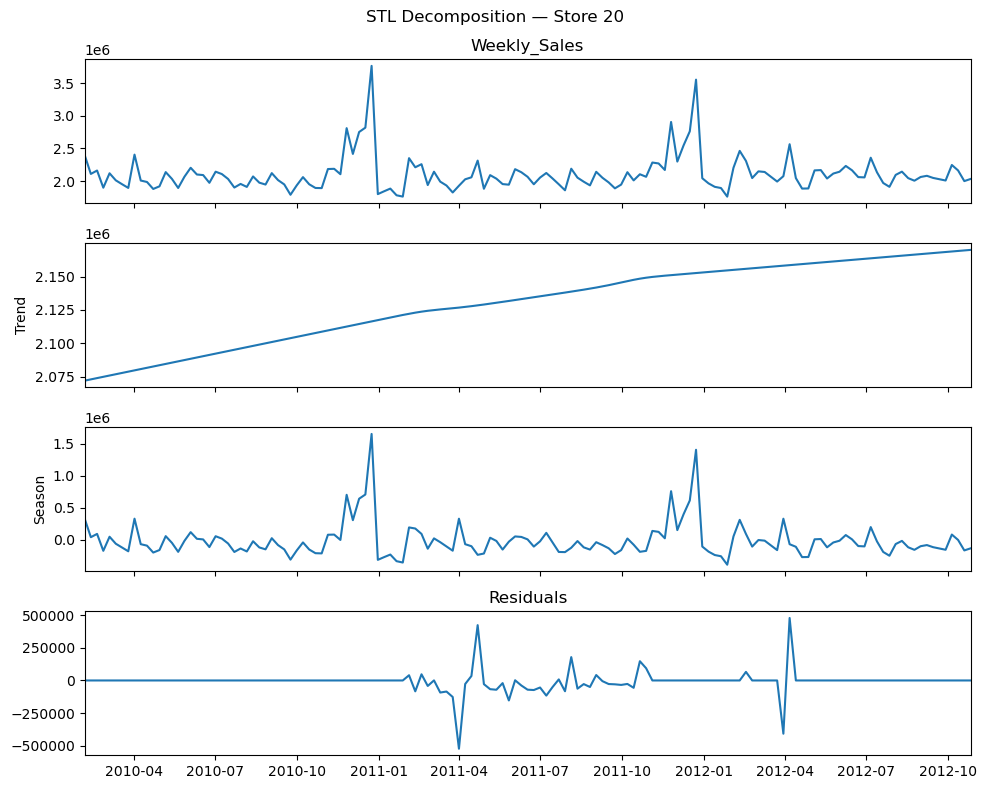

In [36]:
#I am making the assumption based on the graph that seasonality is constant to lets run stl on one representative store
store_id = 20

store_sales = (
    store_weekly_sales
    [store_weekly_sales["Store"] == store_id]
    .sort_values("Date")
    .set_index("Date")["Weekly_Sales"]
)

#run stl on store 20
from statsmodels.tsa.seasonal import STL

stl1 = STL(
    store_sales,
    period=52, #weekly data: yearly seasonality
    robust=True, #reduces impact of holiday spikes
    seasonal=13   # smoother seasonal component
)

result1 = stl1.fit()

fig = result1.plot()
fig.set_size_inches(10, 8)

ax = fig.axes[3]
ax.clear()
ax.plot(result1.resid)
ax.set_title("Residuals")

plt.suptitle("STL Decomposition — Store 20", y=0.98)
plt.tight_layout()
plt.show()


The STL decomposition indicates mild non-stationarity in store-level sales,
characterized by a smooth and slowly varying trend. However, a substantial
portion of variation remains after removing trend and seasonality. Seasonal
effects appear to be driven largely by discrete events rather than smooth
cyclical patterns, suggesting that calendar-based indicators such as holiday
flags will be informative. The remaining residual structure indicates that
short-term deviations potentially driven by promotions and recent sales
dynamics represent meaningful signal rather than pure noise.


## Autocorrelation Structure of Residual Demand

The goal for this step is to answer: Are past deviations informative in predicting future deviations and over what horizon?

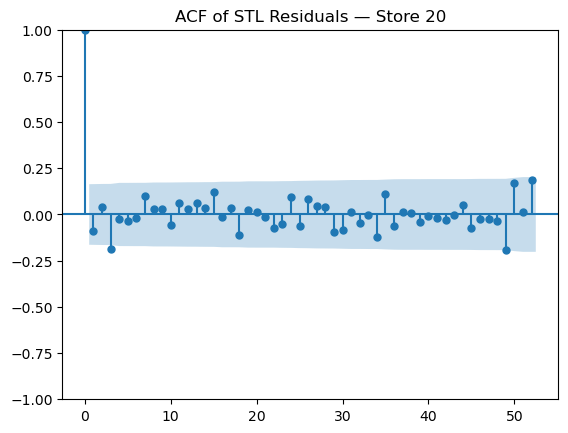

In [37]:
residuals = result1.resid.dropna()
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(
    residuals,
    lags=52,          #up to one year lagged period
    alpha=0.05
)
plt.title("ACF of STL Residuals — Store 20")
plt.show()


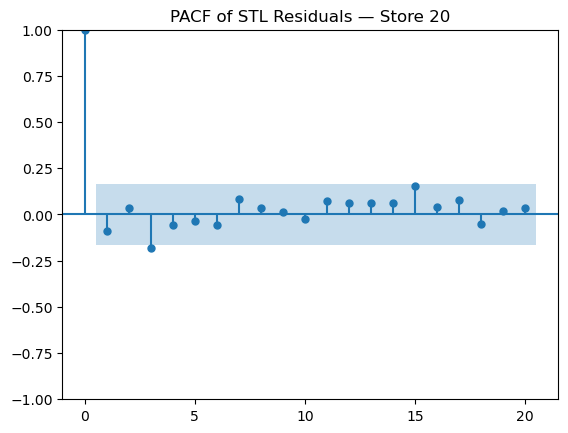

In [38]:
#plot PACF
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(
    residuals,
    lags=20,
    alpha=0.05,
    method="ywm"
)
plt.title("PACF of STL Residuals — Store 20")
plt.show()


Residual autocorrelation is weak, indicating that deviations from baseline
demand do not persist strongly over time. This suggests that short-term
departures from trend are largely event-driven, consistent with holiday and
promotional effects rather than nonlinear momentum in sales.


## Modeling Assumptions and Design Decisions

This analysis frames the problem as a **realistic weekly retail forecasting task**, where predictions must rely only on information available at forecast time.

Because the provided test set includes only **Store, Dept, Date, and IsHoliday**, future promotions and macroeconomic variables are not known at prediction time. As a result, variables such as **MarkDowns, CPI, Unemployment, Fuel Price, and Temperature** will be used only through **lagged values or historical summaries**, with no forward-looking features.

EDA shows that weekly sales are well described by a **smooth long-term trend** with **event-driven deviations**, particularly around holidays. STL decomposition suggests limited persistence in residuals, indicating that deviations are driven more by calendar effects and promotions than by short-term momentum.

ACF and PACF analysis of detrended series shows **weak autocorrelation beyond very short horizons**, motivating the use of **short lags (1–2 weeks, optionally 4)** and **small rolling windows (4–8 weeks)** rather than long autoregressive histories.

MarkDown variables exhibit substantial missingness that varies systematically by **store size and type**, indicating that missingness is **not random**. Each MarkDown feature will therefore be represented using a **promotion-present indicator** alongside an imputed numeric value (e.g., 0 when missing), allowing the model to distinguish between the absence of a promotion and promotion magnitude.

Sales scale and promotional behavior differ meaningfully across stores. To account for this heterogeneity, **Store**, **Type**, and **Size** will be included as contextual features, allowing the model to learn store-specific responses.

Model evaluation will use **time-based (forward-chaining) validation** to reflect real forecasting conditions and avoid leakage from future periods.
